This notebook shows the results of research on HLA-A vs HLA-B predictive ability of random forest.

The tested hypothesis was whether one of these alleles could be a factor which affected the result of immunogenicity prediction.

Different data was used to train the model. To start, dataset contained only amino acid features, then Kyte-Doolittle hydrophobicity scale was added and after that all other hydrophobicity scales (which were correlated a lot, however, a further research should be carried out to find out which of them contain the most valuable information - feature selection is needed). The same steps apply to Kidera factors data.

Finally, the results were assessed altogether. Seems like there is no difference between quality of predictions for allele subsets. However, additional statistical testing may be required to prove this conclusion.

In [35]:
%matplotlib inline
from util.aa_properties import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# "TCR contact residue hydrophobicity is a hallmark of immunogenic CD8+ T cell epitopes" dataset
# TODO: link here

dataset = pd.read_csv('data/pnas_dataset.csv', sep=';')

In [3]:
# some of the columns are read with leading space - replacing column names

dataset.columns = ['Epitope', 'Epitope Start', 'Epitope End', 'MHC Allele',
       'Epitope Source Organism Name', 'Length', 'Immunogenicity']

In [4]:
# function for mice filtering from the dataset

def filter_mice(seq):
    return 'Human' if seq.startswith('HLA') else 'Mouse'

In [41]:
# data preparation pipeline

def prepare_data(df, aa=True, hydropathy=False, hydropathy_all=False, kidera=False):
    
    # creating Host column - 'Human' or 'Mouse'
    df['Host'] = df['MHC Allele'].apply(filter_mice)
    
    # keeping only Human hosts
    df = df.loc[df.Host == 'Human']
    
    # will drop these rows
    to_drop = df.loc[(df['Epitope Source Organism Name'] == 'Homo sapiens') & 
                          (df['Immunogenicity'] == 'Positive')].index
    df.drop(to_drop, inplace=True)
    
    # adding amino acid & kidera scores (sum)
    df = df.merge(df.Epitope.apply(aaprop_sequence), right_index=True, left_index=True)
    
    # here we set columns which will remain in the dataset (either aa props or kidera factors)
    if aa:
        keep = ['alpha', 'charge', 'core', 'pH', 'polarity', 'rim', 'surface', 'turn', 'volume', 'count', 
                'strength', 'disorder', 'mjenergy', 'target', 'Allele']
    elif kidera:
        keep = ['beta', 'kf1', 'kf2', 'kf3', 'kf4', 'kf5', 'kf6', 'kf7', 'kf8', 'kf9', 'kf10', 'Allele', 'target']
        
    # if we do use hydro features at all:
    # whether to use hydro features together
    if hydropathy_all:
        # adding hydrophobicity score (sum)
        scales = ['Kyte-Doolittle', 'Hopp-Woods', 'Cornette', 'Eisenberg', 'Rose', 'Janin', 'Engelman GES']
            
        df = df.merge(df.Epitope.apply(lambda x: score_hydrophobicity_sequence(x, scales)), 
                      right_index=True, left_index=True)
        keep.extend(scales)
        
    # or to keep only Kyte-Doolittle
    elif hydropathy:
        keep.append('hydropathy')
    
    # collecting unique alleles 
    alleles = df['MHC Allele'].unique()
    
    # keeping only 5 first symbols from MHC Allelle (should be: HLA-S*XX:XX)
    alleles_tmp = {allele: allele[:5] for allele in alleles}
    
    # encoder for alleles to get ints
    le = LabelEncoder()
    le.fit(list(set(alleles_tmp.values())))

    # first, mapping alleles to their short versions
    df['allele'] = df['MHC Allele'].map(alleles_tmp)

    # encoding short names
    df['Allele'] = le.transform(df['allele'])
    
    # just to ensure A and B are 0 and 1
    a_b_alleses = le.transform(np.array(['HLA-A', 'HLA-B']))
    
    # encoder for organisms
    # TODO: group organisms?
    le_organisms = LabelEncoder()
    le_organisms.fit(df['Epitope Source Organism Name'])
    df['Organism'] = le_organisms.transform(df['Epitope Source Organism Name'])
    
    # target encoding 
    encode_target = {'Positive': 1, 'Negative': 0}
    df['target'] = df.Immunogenicity.map(encode_target) 
    
    return df[keep]

In [61]:
# train function
# returns OOB score and AUCs for HLA-A and HLA-B

def train(df, random_seed, aa=True, hydropathy=False, hydropathy_all=False, kidera=False):
    
    print(f'Now running with parameters: random_seed={random_seed}, aa={aa}, hydropathy={hydropathy},'
          f' hydropathy_all={hydropathy_all}, kidera={kidera}')
    
    df_train = prepare_data(df, aa=aa, hydropathy=hydropathy, hydropathy_all=hydropathy_all, kidera=kidera)
    
    # making train - test split with stratification by target value and shuffling
    # TODO: set random state?

    X_train, X_test, y_train, y_test = train_test_split(df_train.drop('target', axis=1), df_train.target, 
                                                        test_size=0.3, stratify=df_train.target, shuffle=True, 
                                                        random_state=random_seed)
    
    idx_0 = X_test.loc[X_test.Allele == 0].index
    idx_1 = X_test.loc[X_test.Allele == 1].index
    
    X_test_0 = X_test.loc[idx_0]
    X_test_1 = X_test.loc[idx_1]

    y_test_0 = y_test[idx_0]
    y_test_1 = y_test[idx_1]
    
    # scaling features. scaler is fitted on train data to prevent data leak
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.fit_transform(X_test)
    
    # random forest to try
    # TODO: boolean true?
    # no need in test set actually as oob scoring can be performed

    forest = RandomForestClassifier(n_estimators = 3500, max_depth = 15, max_features = 'sqrt', 
                                    bootstrap='True', n_jobs = -1, oob_score=True, min_samples_leaf=5, 
                                    min_samples_split=5, random_state=random_seed)
    # fitting with train data
    forest.fit(X_train, y_train)
    
    # too lazy to check on test
    # TODO: one day...
    print(f'OOB score = {forest.oob_score_}')
    
    # mapping feature names to scores

    feature_importance = {feature: importance for (feature, importance) in 
                          zip(df_train.drop('target', axis=1).columns, forest.feature_importances_)}
    
    # sorting in descending order
    feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
    print('\nMost important features:')
    for feature in feature_importance[:4]:
        print(f'\t{feature[0]}: {feature[1]}')
    
    y_score_0 = forest.predict_proba(X_test_0)[:, 1]
    y_score_1 = forest.predict_proba(X_test_1)[:, 1]

    y_test = label_binarize(y_test, classes=[0, 1])
    lr_fpr_0, lr_tpr_0, _ = roc_curve(y_test_0, y_score_0)
    lr_fpr_1, lr_tpr_1, _ = roc_curve(y_test_1, y_score_1)
    roc_auc_0 = auc(lr_fpr_0, lr_tpr_0)
    roc_auc_1 = auc(lr_fpr_1, lr_tpr_1)
    plt.plot(lr_fpr_0, lr_tpr_0, marker='.', label=f'HLA-A, AUC = {roc_auc_0:.2f}')
    plt.plot(lr_fpr_1, lr_tpr_1, marker='.', label=f'HLA-B, AUC = {roc_auc_1:.2f}')
    plt.legend()
    
    title = 'ROC, Kidera factors' if kidera else 'ROC, amino acid scores'
    if hydropathy_all:
        title += ' with all hydropathy features'
    elif hydropathy:
        title += ' with hydropathy feature'
    else:
        title += ' no hydropathy'
    plt.title(title)
    plt.show()
    print('\n\n')
    return [forest.oob_score_, roc_auc_0, roc_auc_1]

In [62]:
# feature grid for train 

feature_grid = [[True, False, False, False], [True, True, False, False], [True, False, True, False], 
                [False, False, False, True], [False, True, False, True], [False, False, True, True]]

Now running with parameters: random_seed=7020, aa=True, hydropathy=False, hydropathy_all=False, kidera=False
OOB score = 0.7709260008087343

Most important features:
	Allele: 0.13386782175127723
	polarity: 0.11831575290389783
	rim: 0.10534080556205416
	mjenergy: 0.09147820791199765


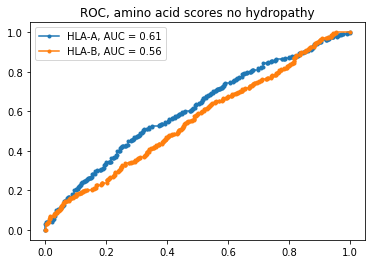




Now running with parameters: random_seed=7020, aa=True, hydropathy=True, hydropathy_all=False, kidera=False
OOB score = 0.770319450060655

Most important features:
	Allele: 0.126703870684575
	hydropathy: 0.10304786889897964
	polarity: 0.09530222480711957
	rim: 0.0927473391554351


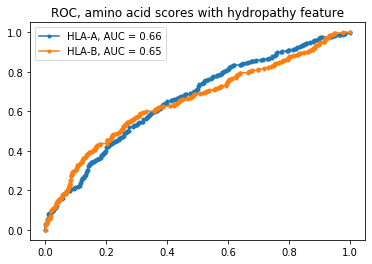




Now running with parameters: random_seed=7020, aa=True, hydropathy=False, hydropathy_all=True, kidera=False
OOB score = 0.7739587545491307

Most important features:
	Allele: 0.10388354495702048
	Engelman GES: 0.08090836212146917
	Cornette: 0.07772634246555128
	Hopp-Woods: 0.06822392688041758


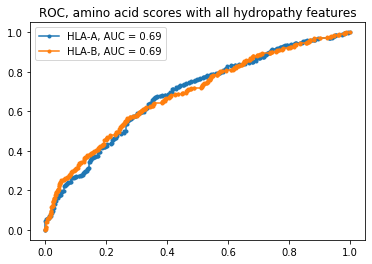




Now running with parameters: random_seed=7020, aa=False, hydropathy=False, hydropathy_all=False, kidera=True
OOB score = 0.7780024262029923

Most important features:
	kf4: 0.260658177923645
	Allele: 0.14529844999355568
	kf7: 0.08165644827087357
	kf6: 0.06949720398768286


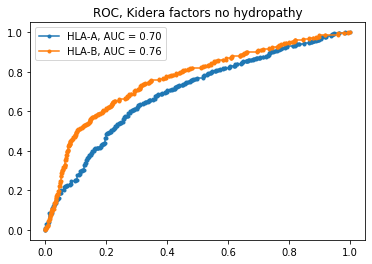




Now running with parameters: random_seed=7020, aa=False, hydropathy=True, hydropathy_all=False, kidera=True
OOB score = 0.7778002426202992

Most important features:
	kf4: 0.20508118396924405
	Allele: 0.12860997937589044
	hydropathy: 0.11802430906781318
	kf7: 0.07655126018974233


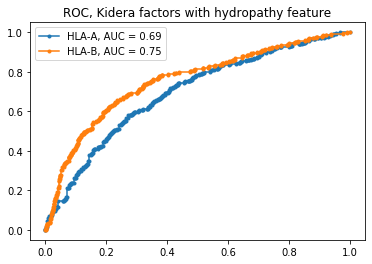




Now running with parameters: random_seed=7020, aa=False, hydropathy=False, hydropathy_all=True, kidera=True
OOB score = 0.7773958754549131

Most important features:
	kf4: 0.12296304224362585
	Allele: 0.10098073277821974
	Cornette: 0.07225073228843205
	Engelman GES: 0.06635531861856837


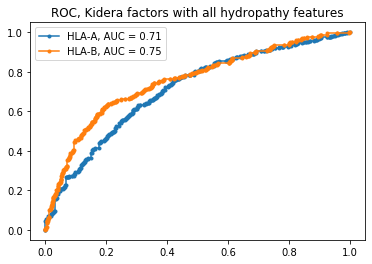

In [69]:
# random state to keep track of them
random_state = np.random.randint(0, 10000)

# results dataset where the returned data will be stored
results = pd.DataFrame(
    columns=['random_seed', 'aa', 'hydropathy', 'hydropathy_all', 'kidera', 'OOB', 'AUC_A', 'AUC_B'])

# applying feature grid
for features in feature_grid:
    
    iteration_result = train(dataset, random_state, *features)
    results.loc[len(results)] = [random_state] + features + iteration_result

In [70]:
results

,random_seed,aa,hydropathy,hydropathy_all,kidera,OOB,AUC_A,AUC_B
0,7020,True,False,False,False,0.770926,0.610177,0.557081
1,7020,True,True,False,False,0.770319,0.661495,0.654399
2,7020,True,False,True,False,0.773959,0.685915,0.687911
3,7020,False,False,False,True,0.778002,0.696110,0.763066
4,7020,False,True,False,True,0.777800,0.693975,0.754226
5,7020,False,False,True,True,0.777396,0.710256,0.752817
